In [1]:
# 需要予測
## 2019年12月の各店舗各商品の売上を予測する
## 提出するCSVは、18店舗×170商品 = 3060行でインデックス・ヘッダ不要

## sales_historyデータは2018年1月1日~2019年10月31日の22ヶ月分のデータ

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install japanize-matplotlib
!pip install pystan
!pip install fbprophet

     |████████████████████████████████| 4.1 MB 7.5 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=0cc0fc9999e79d1539c9e0638067f1cc70ff4136efba1dbc8a3c33fbe7b3deec
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [4]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 16,9
%matplotlib inline

# eが見づらいので、、、
pd.options.display.float_format = '{:.2f}'.format

In [5]:
sales_hist_df = pd.read_csv('/content/drive/MyDrive/AI Quest/code/demand_prediction_aiquest/演習④/data/sales_history.csv')
item_ctg_df = pd.read_csv('/content/drive/MyDrive/AI Quest/code/demand_prediction_aiquest/演習④/data/item_categories.csv')
ctg_name_df = pd.read_csv('/content/drive/MyDrive/AI Quest/code/demand_prediction_aiquest/演習④/data/category_names.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AI Quest/code/demand_prediction_aiquest/演習④/data/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/AI Quest/code/demand_prediction_aiquest/演習④/data/sample_submission.csv', header=None)

In [6]:
# sales_hist_dfの行数
print('sales_hist_df.count(): ' + str(sales_hist_df.count()))

# 売れた商品の数
print('売れた商品の数: ' + str(sales_hist_df['商品ID'].value_counts()))

# 日付の範囲確認
print('日付は ' + str(sales_hist_df['日付'].min()) + ' ~ '  + str(sales_hist_df['日付'].max()) + 'まで')

sales_hist_df.count(): 日付      1119570
店舗ID    1119570
商品ID    1119570
商品価格    1119570
売上個数    1119570
dtype: int64
売れた商品の数: 1100038    4722
1100375    4636
1300239    4539
1100354    4256
1900090    4238
           ... 
1002526       1
1001502       1
1300343       1
1900137       1
1000469       1
Name: 商品ID, Length: 9040, dtype: int64
日付は 2018-01-01 ~ 2019-10-31まで


In [7]:
# とりあえず結合
merged_data = pd.merge(sales_hist_df, item_ctg_df, on='商品ID', how='left')
merged_data = pd.merge(merged_data, ctg_name_df, on='商品カテゴリID', how='left')

merged_data.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名
0,2018-01-01,9,1000001,420,1.00,100,映画 - DVD
1,2018-01-01,6,1000001,420,1.00,100,映画 - DVD
2,2018-01-01,10,1000001,420,1.00,100,映画 - DVD
3,2018-01-01,0,1000017,250,1.00,100,映画 - DVD
4,2018-01-01,1,1000017,250,1.00,100,映画 - DVD


In [8]:
# 「日付」カラムの文字列から、「年」「月」の情報を抽出する
sales_hist_df['年'] = sales_hist_df['日付'].apply(lambda x: x.split('-')[0])
sales_hist_df['月'] = sales_hist_df['日付'].apply(lambda x: x.split('-')[1])

sales_hist_df.head()

,日付,店舗ID,商品ID,商品価格,売上個数,年,月
0,2018-01-01,9,1000001,420,1.00,2018,01
1,2018-01-01,6,1000001,420,1.00,2018,01
2,2018-01-01,10,1000001,420,1.00,2018,01
3,2018-01-01,0,1000017,250,1.00,2018,01
4,2018-01-01,1,1000017,250,1.00,2018,01


In [9]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales_hist_df.groupby(['年', '月']).count().reset_index()[['年', '月']]
gp_time

,年,月
0,2018,01
1,2018,02
2,2018,03
3,2018,04
4,2018,05
5,2018,06
6,2018,07
7,2018,08
8,2018,09
9,2018,10


In [10]:
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': '2019',
    '月': '12'
}, ignore_index=True)

gp_time

,年,月,月ブロック
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4
5,2018,06,5
6,2018,07,6
7,2018,08,7
8,2018,09,8
9,2018,10,9


In [11]:
# 「月ブロック」カラムをsalesに統合する
sales_hist_df = pd.merge(sales_hist_df, gp_time, on=['年', '月'], how='left')
sales_hist_df

,日付,店舗ID,商品ID,商品価格,売上個数,年,月,月ブロック
0,2018-01-01,9,1000001,420,1.00,2018,01,0
1,2018-01-01,6,1000001,420,1.00,2018,01,0
2,2018-01-01,10,1000001,420,1.00,2018,01,0
3,2018-01-01,0,1000017,250,1.00,2018,01,0
4,2018-01-01,1,1000017,250,1.00,2018,01,0
...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.00,2019,10,21
1119566,2019-10-31,7,3400009,1020,1.00,2019,10,21
1119567,2019-10-31,7,3400012,510,1.00,2019,10,21
1119568,2019-10-31,4,3500001,340,1.00,2019,10,21


In [12]:
sales_month = sales_hist_df.groupby('月ブロック').agg({'売上個数': np.sum}).reset_index()
sales_month.head()

,月ブロック,売上個数
0,0,69027.00
1,1,67740.00
2,2,77767.00
3,3,55991.00
4,4,53425.00


<BarContainer object of 22 artists>

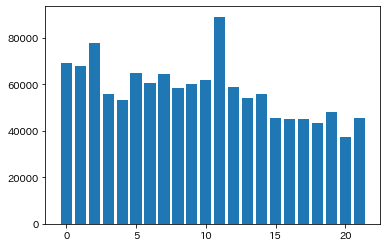

In [13]:
plt.bar(sales_month['月ブロック'], sales_month['売上個数'])

In [49]:
# 上図から、全体的な傾向はダウントレンド、2018年11月の売上個数が伸びているのは何かしらの外的要因が原因か。

In [ ]:
plt.bar(sales_month[])

### 月ごとの売上を集計する(「商品ID」×「店舗ID」)

### ここからは、モデルの学習を行うためのデータセットの作成作業に入る。<br>
### 『各店舗』×『各商品』の組み合わせについて、『2019年12月の1ヶ月間』における『合計売上個数』を予測する<br>
### というのが今回のタスクであるため、学習用データをそれに従って再構成する。

In [14]:
# 「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計を取る
gp_month = sales_hist_df.groupby(['月ブロック',  '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
gp_month

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.00
1,0,1000001,1,2.00
2,0,1000001,2,1.00
3,0,1000001,3,2.00
4,0,1000001,5,2.00
...,...,...,...,...
495129,21,3500070,16,1.00
495130,21,3500071,13,1.00
495131,21,3500072,2,1.00
495132,21,3500072,16,1.00


### 「'月'、'商品ID'、 '店舗ID'」の全組み合わせを作成する

salesデータには、売上が0個の場合の履歴が含まれていない。<br>
そのため、モデルに『売上が0個となる』場合を正しく学習させるには、新たにデータを生成する必要がある。<br>
ここでは、「月」×「商品ID」×「店舗ID」の組み合わせを生成し、元のデータと統合することで、『売上が0個となる』場合も含めた売上履歴データの生成を試みる。

In [15]:
all_combination = []

# '月'、'商品ID'、 '店舗ID'の全組み合わせを作成する
columns = ['月ブロック', '商品ID', '店舗ID']

for i in range(22):
    train_block = sales_hist_df[sales_hist_df['月ブロック']==i]
    all_combination.append(np.array(list(product([i], train_block['商品ID'].unique(), train_block['店舗ID'].unique()))))
    
all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)
all_combination.sort_values(columns, inplace=True)

print(all_combination.info())
all_combination

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648926 entries, 3 to 1644693
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   月ブロック   1648926 non-null  int64
 1   商品ID    1648926 non-null  int64
 2   店舗ID    1648926 non-null  int64
dtypes: int64(3)
memory usage: 50.3 MB
None


,月ブロック,商品ID,店舗ID
3,0,1000001,0
4,0,1000001,1
7,0,1000001,2
15,0,1000001,3
16,0,1000001,4
...,...,...,...
1644680,21,3500073,13
1644694,21,3500073,14
1644679,21,3500073,15
1644685,21,3500073,16


In [16]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
all_train['売上個数'] = all_train['売上個数'].fillna(0)

all_train

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.00
1,0,1000001,1,2.00
2,0,1000001,2,1.00
3,0,1000001,3,2.00
4,0,1000001,4,0.00
...,...,...,...,...
1648921,21,3500073,13,0.00
1648922,21,3500073,14,0.00
1648923,21,3500073,15,0.00
1648924,21,3500073,16,0.00


In [17]:
new_test = test_df.copy()

# 評価対象期間が2019年12月(月ブロック: 23)であるという情報を追加
new_test['月ブロック'] = 23

new_test.head()

,index,商品ID,店舗ID,月ブロック
0,0,1000001,0,23
1,1,1000001,1,23
2,2,1000001,2,23
3,3,1000001,3,23
4,4,1000001,4,23


In [18]:
dataset = pd.concat([all_train, new_test])
dataset

,月ブロック,商品ID,店舗ID,売上個数,index
0,0,1000001,0,6.00,nan
1,0,1000001,1,2.00,nan
2,0,1000001,2,1.00,nan
3,0,1000001,3,2.00,nan
4,0,1000001,4,0.00,nan
...,...,...,...,...,...
3055,23,3500001,13,nan,3055.00
3056,23,3500001,14,nan,3056.00
3057,23,3500001,15,nan,3057.00
3058,23,3500001,16,nan,3058.00


### ラグ特徴量の作成

昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する<br>
ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [19]:
lag = dataset.copy()
    
lag['月ブロック'] = lag['月ブロック'] + 12
lag = lag.rename(columns={'売上個数': '12ヶ月前の売上個数'})
lag

,月ブロック,商品ID,店舗ID,12ヶ月前の売上個数,index
0,12,1000001,0,6.00,nan
1,12,1000001,1,2.00,nan
2,12,1000001,2,1.00,nan
3,12,1000001,3,2.00,nan
4,12,1000001,4,0.00,nan
...,...,...,...,...,...
3055,35,3500001,13,nan,3055.00
3056,35,3500001,14,nan,3056.00
3057,35,3500001,15,nan,3057.00
3058,35,3500001,16,nan,3058.00


In [20]:
# ラグ特徴量の追加
dataset2 = pd.merge(dataset, lag, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
print(dataset2.groupby('月ブロック').agg({'12ヶ月前の売上個数': 'count'}))

       12ヶ月前の売上個数
月ブロック            
0               0
1               0
2               0
3               0
4               0
5               0
6               0
7               0
8               0
9               0
10              0
11              0
12          42354
13          40356
14          40122
15          37296
16          36216
17          36774
18          37746
19          35406
20          31392
21          32508
23           2700


↑ 「月ブロック」0〜11のデータに該当するデータは、12ヶ月前の売上履歴が存在しないので、カラム「12ヶ月前の売上個数」すべて欠損値となる

In [21]:
dataset3 = pd.merge(dataset2, item_ctg_df, on='商品ID', how='left')
dataset3 = pd.merge(dataset3, gp_time, on='月ブロック', how='left')

print(dataset3.info())
dataset3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651986 entries, 0 to 1651985
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   月ブロック       1651986 non-null  int64  
 1   商品ID        1651986 non-null  int64  
 2   店舗ID        1651986 non-null  int64  
 3   売上個数        1648926 non-null  float64
 4   index_x     3060 non-null     float64
 5   12ヶ月前の売上個数  372870 non-null   float64
 6   index_y     0 non-null        float64
 7   商品カテゴリID    1651986 non-null  int64  
 8   年           1651986 non-null  object 
 9   月           1651986 non-null  object 
dtypes: float64(4), int64(4), object(2)
memory usage: 138.6+ MB
None


,月ブロック,商品ID,店舗ID,売上個数,index_x,12ヶ月前の売上個数,index_y,商品カテゴリID,年,月
0,0,1000001,0,6.00,nan,nan,nan,100,2018,01
1,0,1000001,1,2.00,nan,nan,nan,100,2018,01
2,0,1000001,2,1.00,nan,nan,nan,100,2018,01
3,0,1000001,3,2.00,nan,nan,nan,100,2018,01
4,0,1000001,4,0.00,nan,nan,nan,100,2018,01


In [22]:
dataset3['年'] = dataset3['年'].astype(int)
dataset3['月'] = dataset3['月'].astype(int)

In [23]:
dataset3 = dataset3.fillna(0)
dataset3.head()

,月ブロック,商品ID,店舗ID,売上個数,index_x,12ヶ月前の売上個数,index_y,商品カテゴリID,年,月
0,0,1000001,0,6.00,0.00,0.00,0.00,100,2018,1
1,0,1000001,1,2.00,0.00,0.00,0.00,100,2018,1
2,0,1000001,2,1.00,0.00,0.00,0.00,100,2018,1
3,0,1000001,3,2.00,0.00,0.00,0.00,100,2018,1
4,0,1000001,4,0.00,0.00,0.00,0.00,100,2018,1


In [24]:
# 学習用とテスト用に分割
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23)]

test_dataset = dataset3[dataset3['月ブロック'] == 23]

In [25]:
# データセットを入力値、目標値に分割
X_train = train_dataset.drop('売上個数', axis=1)
y_train = train_dataset['売上個数']

X_test = test_dataset.drop(['売上個数'], axis=1)

In [26]:
X_test

,月ブロック,商品ID,店舗ID,index_x,12ヶ月前の売上個数,index_y,商品カテゴリID,年,月
1648926,23,1000001,0,0.00,0.00,0.00,100,2019,12
1648927,23,1000001,1,1.00,0.00,0.00,100,2019,12
1648928,23,1000001,2,2.00,0.00,0.00,100,2019,12
1648929,23,1000001,3,3.00,9.00,0.00,100,2019,12
1648930,23,1000001,4,4.00,7.00,0.00,100,2019,12
...,...,...,...,...,...,...,...,...,...
1651981,23,3500001,13,3055.00,3.00,0.00,350,2019,12
1651982,23,3500001,14,3056.00,0.00,0.00,350,2019,12
1651983,23,3500001,15,3057.00,0.00,0.00,350,2019,12
1651984,23,3500001,16,3058.00,0.00,0.00,350,2019,12


In [27]:
X_train.drop(['index_x', 'index_y'], axis=1)
y_train

989100    2.00
989101    0.00
989102    0.00
989103    5.00
989104    4.00
          ... 
1648921   0.00
1648922   0.00
1648923   0.00
1648924   0.00
1648925   1.00
Name: 売上個数, Length: 659826, dtype: float64

In [28]:
from sklearn.linear_model import LinearRegression

# モデルインスタンスの生成
model_base = LinearRegression()

# モデルの学習
model_base.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
# 学習済みのモデルを使用してテストデータに関する予測値を算出する
y_pred = model_base.predict(X_test)

y_pred

array([0.81834083, 0.80720594, 0.79607104, ..., 0.21939857, 0.20826367,
       0.29310376])

In [30]:
train_df = all_train
train_df

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.00
1,0,1000001,1,2.00
2,0,1000001,2,1.00
3,0,1000001,3,2.00
4,0,1000001,4,0.00
...,...,...,...,...
1648921,21,3500073,13,0.00
1648922,21,3500073,14,0.00
1648923,21,3500073,15,0.00
1648924,21,3500073,16,0.00


In [31]:
# Cross Validation
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    train_df.loc[valid_idx, "fold"] = fold
print(train_df["fold"].value_counts())

0.00    329786
1.00    329785
4.00    329785
3.00    329785
2.00    329785
Name: fold, dtype: int64


In [32]:
# とりあえずfold=0を検証用データとする
fold = 0
train = train_df[train_df['fold'] != fold].copy()
valid = train_df[train_df['fold'] == fold].copy()
print(train.shape, valid.shape)

(1319140, 5) (329786, 5)


In [33]:
X_train = train.loc[:, ['月ブロック', '商品ID', '店舗ID']]
X_valid = valid.loc[:, ['月ブロック', '商品ID', '店舗ID']]
X_pred = X_test.loc[:, ['月ブロック', '商品ID', '店舗ID']]
y_train = train.loc[:, '売上個数']
y_valid = valid.loc[:, '売上個数']


In [34]:
# データ数が少ないためLightGBMではなくXGBoostを選択
import xgboost as xgb

# XGBoost専用のDMatrix形式に変換
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

In [35]:
# パラメーターの設定(評価関数はコンペで定められているRMSE:平均二乗誤差を採用)
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

In [36]:
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")],
    num_boost_round = 100
)

[0]	train-rmse:2.83769	valid-rmse:3.05947
[1]	train-rmse:2.78937	valid-rmse:3.01332
[2]	train-rmse:2.768	valid-rmse:2.99625
[3]	train-rmse:2.75521	valid-rmse:2.98725
[4]	train-rmse:2.72296	valid-rmse:2.9589
[5]	train-rmse:2.6953	valid-rmse:2.93469
[6]	train-rmse:2.68724	valid-rmse:2.9279
[7]	train-rmse:2.67263	valid-rmse:2.91512
[8]	train-rmse:2.66731	valid-rmse:2.91159
[9]	train-rmse:2.65727	valid-rmse:2.90311
[10]	train-rmse:2.65102	valid-rmse:2.89786
[11]	train-rmse:2.64185	valid-rmse:2.8904
[12]	train-rmse:2.62541	valid-rmse:2.87683
[13]	train-rmse:2.61667	valid-rmse:2.86918
[14]	train-rmse:2.61142	valid-rmse:2.86451
[15]	train-rmse:2.59623	valid-rmse:2.85279
[16]	train-rmse:2.58054	valid-rmse:2.83752
[17]	train-rmse:2.57059	valid-rmse:2.81753
[18]	train-rmse:2.56666	valid-rmse:2.81405
[19]	train-rmse:2.55114	valid-rmse:2.80016
[20]	train-rmse:2.53724	valid-rmse:2.78708
[21]	train-rmse:2.53098	valid-rmse:2.78271
[22]	train-rmse:2.52983	valid-rmse:2.78153
[23]	train-rmse:2.52111	val

In [37]:
pred = model.predict(xgb.DMatrix(X_valid))
print(pred)

[-0.18874508  0.04657573  3.1425462  ...  0.20932442  0.20883429
 -0.01313114]


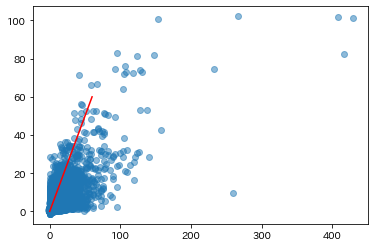

In [38]:
plt.scatter(y_valid, pred, alpha = 0.5)
plt.plot(np.linspace(0, 60, 100), np.linspace(0, 60, 100), "red")
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, pred)
rmse = np.sqrt(mse)
print(rmse)

2.315841012892368


In [40]:
results_dict = {}
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")],
    num_boost_round = 100,
    evals_result = results_dict
)

[0]	train-rmse:2.83769	valid-rmse:3.05947
[1]	train-rmse:2.78937	valid-rmse:3.01332
[2]	train-rmse:2.768	valid-rmse:2.99625
[3]	train-rmse:2.75521	valid-rmse:2.98725
[4]	train-rmse:2.72296	valid-rmse:2.9589
[5]	train-rmse:2.6953	valid-rmse:2.93469
[6]	train-rmse:2.68724	valid-rmse:2.9279
[7]	train-rmse:2.67263	valid-rmse:2.91512
[8]	train-rmse:2.66731	valid-rmse:2.91159
[9]	train-rmse:2.65727	valid-rmse:2.90311
[10]	train-rmse:2.65102	valid-rmse:2.89786
[11]	train-rmse:2.64185	valid-rmse:2.8904
[12]	train-rmse:2.62541	valid-rmse:2.87683
[13]	train-rmse:2.61667	valid-rmse:2.86918
[14]	train-rmse:2.61142	valid-rmse:2.86451
[15]	train-rmse:2.59623	valid-rmse:2.85279
[16]	train-rmse:2.58054	valid-rmse:2.83752
[17]	train-rmse:2.57059	valid-rmse:2.81753
[18]	train-rmse:2.56666	valid-rmse:2.81405
[19]	train-rmse:2.55114	valid-rmse:2.80016
[20]	train-rmse:2.53724	valid-rmse:2.78708
[21]	train-rmse:2.53098	valid-rmse:2.78271
[22]	train-rmse:2.52983	valid-rmse:2.78153
[23]	train-rmse:2.52111	val

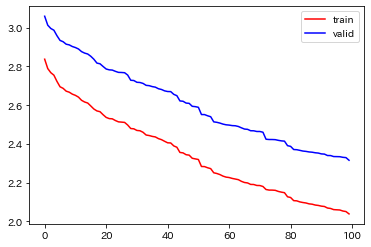

In [41]:
plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
plt.plot(results_dict["valid"]["rmse"], color = "blue", label = "valid")
plt.legend()
plt.show()

[0.5022265  0.2748477  0.71250206 ... 0.07876709 0.05949742 0.20357582]
最小値: -0.16782951 最大値: 15.859293


(array([2.741e+03, 2.350e+02, 4.500e+01, 9.000e+00, 2.600e+01, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.16782951,  1.4348828 ,  3.037595  ,  4.6403074 ,  6.2430196 ,
         7.8457317 ,  9.448444  , 11.051156  , 12.653869  , 14.25658   ,
        15.859293  ], dtype=float32),
 <a list of 10 Patch objects>)

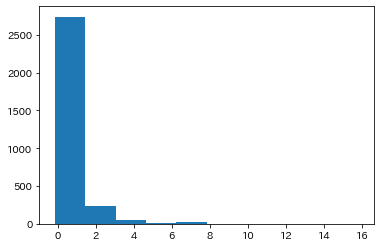

In [42]:
pred = model.predict(xgb.DMatrix(X_pred))
print(pred)
print('最小値: ' + str(min(pred)) + ' 最大値: ' + str(max(pred)))
plt.hist(pred)

In [43]:
processed_pred = list(map(lambda x: 0 if x < 0 else x, pred))

In [44]:
# sample_submissionの右側のカラムに予測値を代入する。
# sub.iloc[:, -1] = y_pred

# sub.head()

In [45]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = processed_pred
print(len(sub))
sub.head()

3060


,0,1
0,0,0.50
1,1,0.27
2,2,0.71
3,3,2.86
4,4,4.84


In [46]:
import datetime as dt
custom_date = dt.datetime.now().strftime('%Y%m%d')
custom_date

'20211004'

In [47]:
filename = '(xgbboost_score_)submission_' + custom_date + '.csv'

In [48]:
# 予測ファイルの生成
sub.to_csv(filename, index=False, header=False)